In [1]:
# Import library 

import pandas as pd
import re
from collections import defaultdict, Counter
import networkx as nx
import matplotlib.pyplot as plt
import community
import numpy as np
import random
import pickle
import os
from adjustText import adjust_text

# Load Dataset

In [2]:
data = pd.read_csv('sustainability_db.detik_berita.csv')

# 1. Preprocessing Data

In [3]:
# Konversi kolom tanggal ke datetime, hapus data yang gagal parse
data['tanggal'] = pd.to_datetime(data['tanggal'], errors='coerce')
data = data.dropna(subset=['tanggal'])

# Definisikan stopwords gabungan
stopwords_id = {
    'yang', 'dan', 'untuk', 'dari', 'dengan', 'pada', 'oleh', 'atau', 'ini', 'itu',
    'ke', 'sebagai', 'di', 'juga', 'tidak', 'akan', 'adalah', 'karena', 'telah',
    'lebih', 'dalam', 'tersebut', 'bagi', 'mereka', 'sudah', 'antara', 'setelah',
    'agar', 'bahwa', 'bisa', 'menjadi', 'ada', 'pt', 'rp', 'pertamina', 'kita',
    'saya', 'hari', 'ia', 'kerja', 'sama', 'dia', 'kepada', 'lain', 'para', 'sehingga', 'beberapa', 'hingga', 'terus', 'baru',
    'harus', 'jadi', 'banyak', 'mencapai', 'selama', 'juta', 'seluruh', 'masih', 'mulai', 'terhadap',
    'lalu', 'bidang'
}
custom_stopwords = {
    'to', 'with', 'the', 'and', 'of', 'in', 'on', 'for', 'a', 'scroll', 'content',
    'continue', 'an', 'is', 'it', 'at', 'this', 'that', 'by', 'as', 'from'
}
additional_stopwords = {
    'indonesia', 'tahun', 'dapat', 'serta', 'seperti', 'satu', 'secara',
    'merupakan', 'salah', 'melalui', 'saat', 'hal', 'berbagai', 'hanya',
    'selain', 'memiliki', 'kami', 'baik', 'kata', 'memberikan',
    'masyarakat', 'meningkatkan', 'dunia', 'sangat', 'utama'
}
stopwords_all = stopwords_id.union(custom_stopwords).union(additional_stopwords)

# Fungsi preprocessing teks
def preprocess_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text

def simple_tokenize(text):
    tokens = text.split()
    return [word for word in tokens if word not in stopwords_all]

# Gabungkan judul dan isi, preprocess dan tokenisasi
data['cleaned'] = (data['judul'].fillna('') + ' ' + data['isi_berita'].fillna('')).apply(preprocess_text)
data['tokens'] = data['cleaned'].apply(simple_tokenize)

In [4]:
print(f"Jumlah data setelah preprocessing: {len(data)}")
print(data.isnull().sum())

Jumlah data setelah preprocessing: 4051
_id             0
judul           0
tanggal         0
author          6
description     0
tags           24
link            0
isi_berita      0
thumbnail       0
cleaned         0
tokens          0
dtype: int64


# 2. Analisis Tren Jumlah Berita Harian

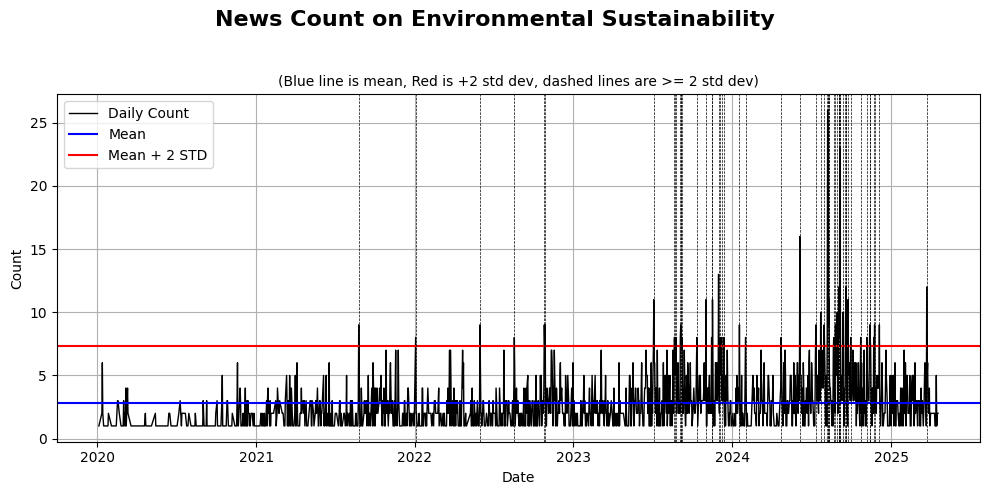

In [5]:
# Hitung jumlah berita per hari
daily_counts = data.groupby(data['tanggal'].dt.date).size().reset_index(name='jumlah_berita')
daily_counts['tanggal'] = pd.to_datetime(daily_counts['tanggal'])

# Statistik
mean_count = daily_counts['jumlah_berita'].mean()
std_count = daily_counts['jumlah_berita'].std()
threshold = mean_count + 2 * std_count
daily_counts['outlier'] = daily_counts['jumlah_berita'] >= threshold

# Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(daily_counts['tanggal'], daily_counts['jumlah_berita'], color='black', linewidth=1, label='Daily Count')
plt.axhline(mean_count, color='blue', linestyle='-', label='Mean')
plt.axhline(threshold, color='red', linestyle='-', label='Mean + 2 STD')
for tanggal in daily_counts[daily_counts['outlier']]['tanggal']:
    plt.axvline(tanggal, color='black', linestyle='--', linewidth=0.5)
plt.suptitle("News Count on Environmental Sustainability", fontsize=16, fontweight='bold')
plt.title("(Blue line is mean, Red is +2 std dev, dashed lines are >= 2 std dev)", fontsize=10)
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("sustainability_news_peak_graph.png", dpi=300)
plt.show()

In [6]:
# Hitung jumlah berita per hari
daily_counts = data.groupby(data['tanggal'].dt.date).size().reset_index(name='jumlah_berita')
daily_counts['tanggal'] = pd.to_datetime(daily_counts['tanggal'])

# Hitung statistik
mean_count = daily_counts['jumlah_berita'].mean()
std_count = daily_counts['jumlah_berita'].std()
threshold = mean_count + 2 * std_count

# Tandai outlier
daily_counts['outlier'] = daily_counts['jumlah_berita'] >= threshold

# Hitung total berita
total_berita = daily_counts['jumlah_berita'].sum()

# Hitung jumlah hari outlier
jumlah_outlier = daily_counts['outlier'].sum()

# Tampilkan informasi
print(f"Total berita: {total_berita}")
print(f"Rata-rata harian: {mean_count:.2f}")
print(f"Standar deviasi: {std_count:.2f}")
print(f"Ambang batas outlier: {threshold:.2f}")
print(f"Jumlah hari outlier: {jumlah_outlier}")


Total berita: 4051
Rata-rata harian: 2.82
Standar deviasi: 2.25
Ambang batas outlier: 7.32
Jumlah hari outlier: 56


# 3. Buat Co-occurrence Network dengan Sliding Window

In [7]:
window_size = 5
co_occurrence = defaultdict(int)

for tokens in data['tokens']:
    for i in range(len(tokens)):
        for j in range(i+1, min(i + window_size, len(tokens))):
            if tokens[i] != tokens[j]:
                pair = tuple(sorted((tokens[i], tokens[j])))
                co_occurrence[pair] += 1

In [8]:
# Bangun graf dengan threshold bobot minimal 80
G = nx.Graph()
for (w1, w2), weight in co_occurrence.items():
    if weight >= 80:
        G.add_edge(w1, w2, weight=weight)

print(f"Jumlah simpul (nodes): {G.number_of_nodes()}")
print(f"Jumlah sisi (edges): {G.number_of_edges()}")

Jumlah simpul (nodes): 713
Jumlah sisi (edges): 1381


In [10]:
# Hitung frekuensi kata
all_words = [word for tokens in data['tokens'] for word in tokens]
word_freq = dict(Counter(all_words).most_common(50))

degree_dict = dict(G.degree())
eigencentrality = nx.eigenvector_centrality(G, weight='weight')

df_top = pd.DataFrame({
    'Word': list(word_freq.keys()),
    'Frequency': list(word_freq.values())
})
df_top['Degree'] = df_top['Word'].map(degree_dict)
df_top['Eigencentrality'] = df_top['Word'].map(eigencentrality)

In [11]:
print(df_top.sort_values(by='Frequency', ascending=False).head(50))

              Word  Frequency  Degree  Eigencentrality
0       lingkungan       6658      87         0.260503
1           energi       5601      87         0.285462
2       perusahaan       5282      52         0.202185
3          program       5066      48         0.123354
4          ekonomi       3857      41         0.108784
5           bisnis       3505      38         0.179822
6        mendukung       3356      34         0.196448
7   sustainability       3250      24         0.059955
8    berkelanjutan       3216      43         0.146503
9       pemerintah       3105      25         0.073191
10        industri       3085      18         0.050860
11          negara       2903      17         0.023349
12       dilakukan       2855      10         0.035270
13      mengatakan       2839       9         0.016533
14       melakukan       2773      11         0.037648
15          produk       2765      11         0.016755
16         jakarta       2677      24         0.000765
17        

In [12]:
# Export ke file .csv
df_top = df_top[['Word', 'Frequency', 'Degree', 'Eigencentrality']]
df_top.to_csv("top50_kata_sna.csv", index=False)

# 4. Louvain Clustering pada Subgraph Top 50 Kata

In [18]:
random.seed(42)
top_words = set(df_top['Word'])
G_sub = G.subgraph(top_words).copy()

# Load hasil clustering jika ada, jika tidak buat dan simpan
if os.path.exists("louvain_partition.pkl"):
    with open("louvain_partition.pkl", "rb") as f:
        partition = pickle.load(f)
else:
    partition = community.best_partition(G_sub, random_state=42)
    with open("louvain_partition.pkl", "wb") as f:
        pickle.dump(partition, f)

max_cluster = 4
cluster_counts = Counter(partition.values())
top_clusters = set([cl for cl, _ in cluster_counts.most_common(max_cluster)])

# Stabilkan cluster node di luar top_clusters dengan tetangga
for node in partition:
    if partition[node] not in top_clusters:
        neighbors = list(G_sub.neighbors(node))
        neighbor_clusters = [partition.get(n) for n in neighbors if partition.get(n) in top_clusters]
        if neighbor_clusters:
            partition[node] = Counter(neighbor_clusters).most_common(1)[0][0]
        else:
            partition[node] = random.choice(list(top_clusters))

unique_clusters = sorted(set(partition.values()))
cluster_to_color_idx = {cl: i for i, cl in enumerate(unique_clusters)}
partition_remapped = {node: cluster_to_color_idx[partition[node]] for node in G_sub.nodes()}

# Update dataframe dengan cluster info
df_top = df_top[df_top['Word'].isin(G_sub.nodes())].copy()
df_top['Cluster'] = df_top['Word'].map(partition_remapped).astype(int)

# Normalisasi skor untuk font size dan analisis
df_top['Frequency_norm'] = (df_top['Frequency'] - df_top['Frequency'].min()) / (df_top['Frequency'].max() - df_top['Frequency'].min())
df_top['Degree_norm'] = (df_top['Degree'] - df_top['Degree'].min()) / (df_top['Degree'].max() - df_top['Degree'].min())
df_top['Eigencentrality_norm'] = (df_top['Eigencentrality'] - df_top['Eigencentrality'].min()) / (df_top['Eigencentrality'].max() - df_top['Eigencentrality'].min())
df_top['CombinedScore'] = (df_top['Frequency_norm'] + df_top['Degree_norm'] + df_top['Eigencentrality_norm']) / 3

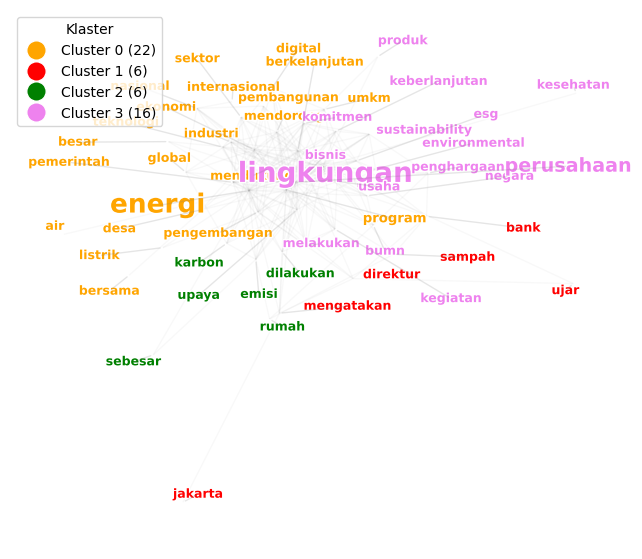

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.patheffects as patheffects
from collections import Counter

# Font size dinamis berdasarkan CombinedScore
font_sizes = {
    node: max(df_top.set_index('Word').loc[node]['CombinedScore'] * 18, 9)
    for node in G_sub.nodes()
}

# Highlight node besar
highlight_nodes = ['lingkungan', 'energi', 'perusahaan']
for node in highlight_nodes:
    if node in font_sizes:
        font_sizes[node] *= 1.2

# Warna klaster
warna_custom = ['orange', 'red', 'green', 'violet']
label_colors = {node: warna_custom[partition_remapped[node]] for node in G_sub.nodes()}

# Layout jaringan (lebih renggang)
pos = nx.spring_layout(G_sub, k=0.25, seed=42)

# Normalisasi & sentralisasi posisi
pos_array = np.array(list(pos.values()))
min_pos, max_pos = pos_array.min(axis=0), pos_array.max(axis=0)
range_pos = max_pos - min_pos
for node in pos:
    x, y = pos[node]
    pos[node] = ((x - min_pos[0]) / range_pos[0] * 0.9 + 0.05,
                 (y - min_pos[1]) / range_pos[1] * 0.9 + 0.05)
center_x, center_y = 0.5, 0.5
centroid_x, centroid_y = np.mean(pos_array[:, 0]), np.mean(pos_array[:, 1])
offset_x, offset_y = center_x - centroid_x, center_y - centroid_y
for node in pos:
    x, y = pos[node]
    pos[node] = (x + offset_x, y + offset_y)

# Geser node spesifik (manual)
for node in ["jakarta", "air", "internasional", "sebesar"]:
    if node in pos:
        x, y = pos[node]
        dx, dy = center_x - x, center_y - y
        pos[node] = (x + dx * 0.2, y + dy * 0.2)

for node in ["internasional", "bersama", "kesehatan", "ujar"]:
    if node in pos:
        x, y = pos[node]
        pos[node] = (x + 0.3, y)  # Geser ke kanan saja

# Final penyesuaian posisi manual untuk merapikan layout
pos_adjust_manual = {
    "jakarta": (-0.08, -0.05),
    "bersama": (-0.12, -0.10),
    "rumah": (-0.15, 0.00),  # Geser lebih jauh ke kiri
}

for node, (dx, dy) in pos_adjust_manual.items():
    if node in pos:
        x, y = pos[node]
        pos[node] = (x + dx, y + dy)


# Plot
plt.figure(figsize=(8, 7), facecolor='white')
nx.draw_networkx_edges(G_sub, pos, alpha=0.05, edge_color="gray")

# Label dengan outline putih
texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(
        x, y, node,
        fontsize=font_sizes[node],
        fontweight='bold',
        color=label_colors[node],
        ha='center', va='center',
        path_effects=[patheffects.withStroke(linewidth=2, foreground="white")]
    ))

# Hindari label tumpang tindih
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.2),
    expand_text=(1.1, 1.1),
    force_text=0.7,
    force_points=0.5
)

# Legend jumlah node per klaster
klaster_counts = Counter(partition_remapped.values())
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               label=f"Cluster {i} ({klaster_counts[i]})",
               markerfacecolor=warna_custom[i], markersize=14)
    for i in range(len(warna_custom))
]
plt.legend(handles=handles, title='Klaster', loc='upper left')

# plt.title("Clustered Keyword Co-Occurrence Network (Top 50 Words)", fontsize=16)
plt.axis('off')
plt.savefig("network_clustered_top50words_refined.png", dpi=300, bbox_inches="tight")
plt.show()


In [20]:
df_clustered_sorted = df_top.sort_values(by=['Cluster', 'CombinedScore'], ascending=[True, False])
print(df_clustered_sorted.head(5))

            Word  Frequency  Degree  Eigencentrality  Cluster  Frequency_norm  \
1         energi       5601      87         0.285462        0        0.783402   
3        program       5066      48         0.123354        0        0.673770   
6      mendukung       3356      34         0.196448        0        0.323361   
8  berkelanjutan       3216      43         0.146503        0        0.294672   
4        ekonomi       3857      41         0.108784        0        0.426025   

   Degree_norm  Eigencentrality_norm  CombinedScore  
1     1.000000              0.851004       0.878135  
3     0.546512              0.366438       0.528907  
6     0.383721              0.584928       0.430670  
8     0.488372              0.435636       0.406227  
4     0.465116              0.322888       0.404676  


In [21]:
df_clustered_sorted.to_csv('clustered_keywords_metrics_sorted.csv', index=False)

In [22]:
clusters = sorted(df_clustered_sorted['Cluster'].unique())

for cluster in clusters:
    top_words = df_clustered_sorted[df_clustered_sorted['Cluster'] == cluster].sort_values(by='Frequency', ascending=False).head(6)['Word'].tolist()
    print(f"Cluster {cluster} top words: {', '.join(top_words)}")

Cluster 0 top words: energi, program, ekonomi, mendukung, berkelanjutan, pemerintah
Cluster 1 top words: mengatakan, jakarta, bank, direktur, sampah, ujar
Cluster 2 top words: dilakukan, upaya, emisi, karbon, sebesar, rumah
Cluster 3 top words: lingkungan, perusahaan, bisnis, sustainability, negara, melakukan


In [23]:
for cluster in clusters:
    cluster_nodes = df_clustered_sorted[df_clustered_sorted['Cluster'] == cluster]['Word'].tolist()
    cluster_edges = [(u, v, d['weight']) for u, v, d in G_sub.edges(data=True) if u in cluster_nodes and v in cluster_nodes]
    top_edges = sorted(cluster_edges, key=lambda x: x[2], reverse=True)[:3]
    print(f"\nCluster {cluster} Top Associations:")
    for u, v, w in top_edges:
        print(f"  {u} – {v} (count: {w})")


Cluster 0 Top Associations:
  mendukung – energi (count: 587)
  berkelanjutan – pembangunan (count: 466)
  pemerintah – mendukung (count: 345)

Cluster 1 Top Associations:
  bank – sampah (count: 172)
  mengatakan – direktur (count: 114)
  direktur – ujar (count: 114)

Cluster 2 Top Associations:
  emisi – karbon (count: 874)
  rumah – emisi (count: 263)
  upaya – dilakukan (count: 211)

Cluster 3 Top Associations:
  esg – environmental (count: 968)
  bisnis – esg (count: 418)
  lingkungan – perusahaan (count: 344)


# 5. Analisis Tema Cluster

In [24]:
themes = {
    0: "Dukungan Pemerintah dan Program Ekonomi untuk Pembangunan Energi Berkelanjutan",
    1: "Isu Pengelolaan Sampah dan Peran Institusi Keuangan di Jakarta",
    2: "Upaya Pengurangan Emisi Karbon pada Sektor Perumahan",
    3: "Implementasi ESG dan Praktik Bisnis Berkelanjutan oleh Perusahaan"
}
cluster_colors = {0: "orange", 1: "red", 2: "green", 3: "violet"}
total_freq = df_clustered_sorted['Frequency'].sum()

rows = []
for cluster in clusters:
    cluster_nodes = df_clustered_sorted[df_clustered_sorted['Cluster'] == cluster]['Word'].tolist()
    cluster_edges = [(u, v, d['weight']) for u, v, d in G_sub.edges(data=True) if u in cluster_nodes and v in cluster_nodes]
    top_edges = sorted(cluster_edges, key=lambda x: x[2], reverse=True)[:3]
    associations = [f"{u} – {v}" for u, v, _ in top_edges]
    counts = [str(w) for _, _, w in top_edges]
    cluster_freq = df_clustered_sorted[df_clustered_sorted['Cluster'] == cluster]['Frequency'].sum()
    share = cluster_freq / total_freq * 100

    rows.append({
        "Theme": themes.get(cluster, f"Cluster {cluster}"),
        "Top associations": ", ".join(associations),
        "Association count": ", ".join(counts),
        "Cluster color": cluster_colors.get(cluster, "gray"),
        "Share of network (%)": f"{share:.2f}"
    })

theme_df = pd.DataFrame(rows)
print(theme_df.to_string(index=False))
theme_df.to_csv('theme_summary.csv', index=False)
print("File CSV sudah tersimpan dengan nama 'theme_summary.csv'.")

                                                                         Theme                                                        Top associations Association count Cluster color Share of network (%)
Dukungan Pemerintah dan Program Ekonomi untuk Pembangunan Energi Berkelanjutan mendukung – energi, berkelanjutan – pembangunan, pemerintah – mendukung     587, 466, 345        orange                44.87
                Isu Pengelolaan Sampah dan Peran Institusi Keuangan di Jakarta                   bank – sampah, mengatakan – direktur, direktur – ujar     172, 114, 114           red                10.56
                          Upaya Pengurangan Emisi Karbon pada Sektor Perumahan                        emisi – karbon, rumah – emisi, upaya – dilakukan     874, 263, 211         green                10.07
             Implementasi ESG dan Praktik Bisnis Berkelanjutan oleh Perusahaan              esg – environmental, bisnis – esg, lingkungan – perusahaan     968, 418, 344        violet  